<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/regression_drift_0516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [4]:
data_size = 40000
cor = [2.5, 2.0, 1.5 , 1.0, 0.5]

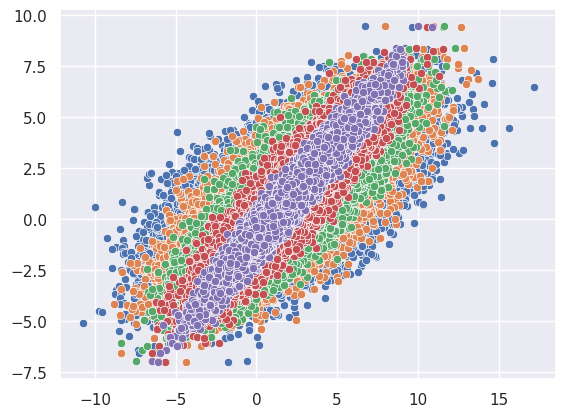

In [5]:
seed_everything()
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

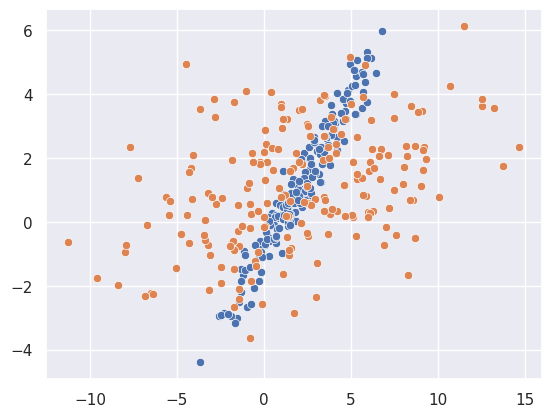

In [6]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.810444
x2    0.512920
x1    0.350373
z0    0.255009
x0    0.238650
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

Bucket size:200 step_size:200


100%|██████████| 200/200 [00:06<00:00, 33.03it/s]


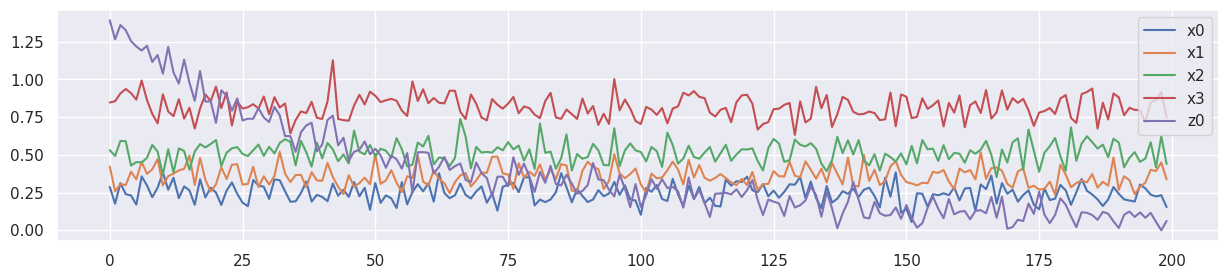

In [9]:
from tqdm import tqdm

bucket_size_array=[200] #[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

## ks-test 

In [10]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

Bucket size:200 step_size:200


 78%|███████▊  | 156/200 [00:00<00:00, 1549.86it/s]<ipython-input-10-160e0953fd26>:11: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
100%|██████████| 200/200 [00:00<00:00, 1289.13it/s]


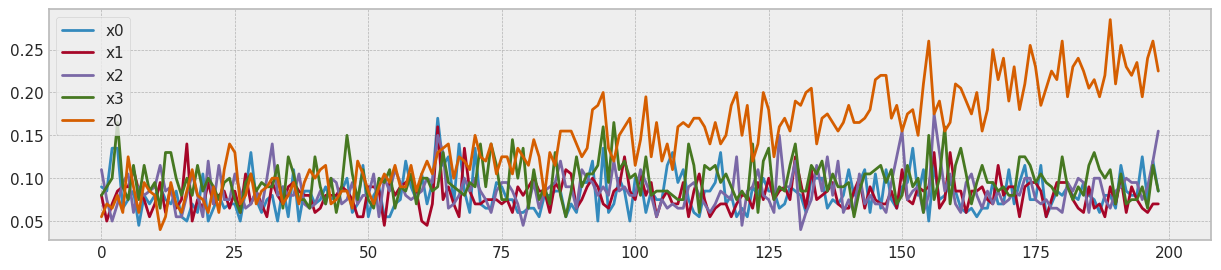

In [11]:

from tqdm import tqdm

bucket_size_array=[200] #[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)

        ks = __ks_drift(X[0:bucket_size].values,X[bk*bucket_size+bucket_size:bk*bucket_size+bucket_size+bucket_size].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 31.53it/s]


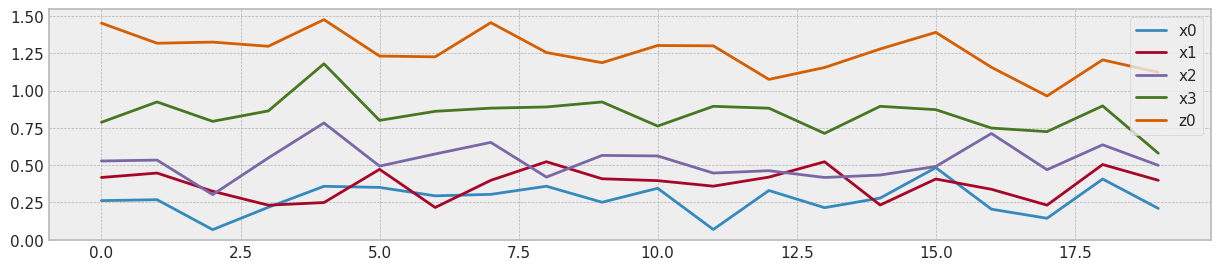

In [12]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


MSE: 0.26
RMSE: 0.51


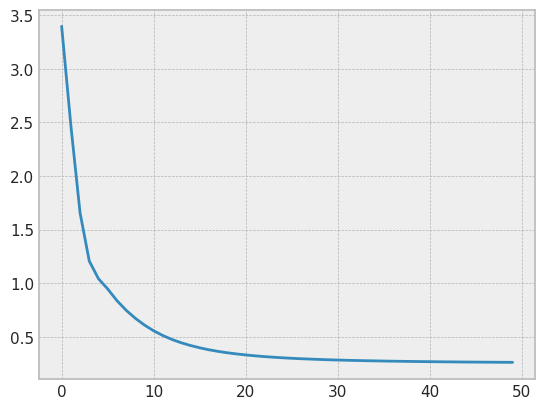

In [13]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)


print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

+ R2 측정

In [14]:
from sklearn.metrics import r2_score
predicted_y = model(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9366745203034739


+ 2000~40000까지의 R-squared score 측정 

100%|██████████| 190/190 [00:00<00:00, 1726.04it/s]


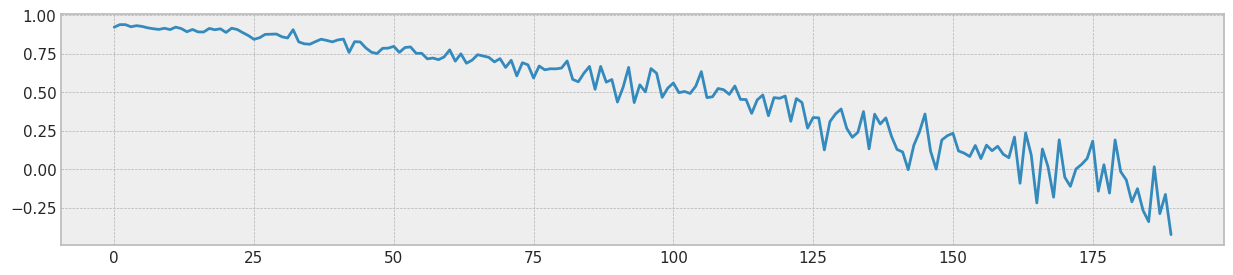

In [15]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    r2s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        r2 = r2_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y.detach().numpy())
        r2s.append(r2)
    plt.figure(figsize=(15,3))
    plt.plot(r2s)
    plt.show()


# Generator + Discriminator 구조

+ Generator에 control factor 'z' 를 대입하여, r2가 1~0 까지 전개되도록 학습한다.

$$
L=mse(D(G(x,z=0)),y) - mse(D(G(x,z=1),y)) 
$$

+ 하지만, 뒷 부분의 항 $  - mse(D(G(x,z=1),y)) $ 는 최소화 되기 위해 값이 계속 커지기 때문에 전체 loss fucntion은 뒤 항에 지배적이 되고 실제 학습 효과가 있는 앞의 항은 학습되지 못 한다. 
+ 따라서, 뒷 부분의 항을 조절하기 위해 log(softmax(x)) 를 취하여 [-inf,0]의 범위에 있도록 한다.
+ log(softmax(x)) 가 0에 수렴 할 수록, 앞 항의 학습 효과가 발생하여 전체적인 학습이 이루어지게 된다.

$$
L=mse(D(G(x,z=0)),y) - log(softmax(mse(D(G(x,z=1),y)))) 
$$

In [16]:

# Define the Generator
class Generator(nn.Module):

    def __init__(self, input_dim):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim)
        )

    def forward(self, x,b):
        input_data = torch.cat((x,torch.zeros(x.shape[0],1) + b),1)        
        output = self.model(input_data)
        return output
 

In [17]:

# Define the regression model
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, input_data):
        output = self.model(input_data)
        return output

  2%|▏         | 1/50 [00:00<00:15,  3.13it/s]

[Epoch 0/50] [A loss: 0.338593] [B loss: 0.482029] [G loss: 0.820622]


 22%|██▏       | 11/50 [00:03<00:12,  3.10it/s]

[Epoch 10/50] [A loss: 0.246763] [B loss: 0.000166] [G loss: 0.246929]


 42%|████▏     | 21/50 [00:06<00:09,  2.99it/s]

[Epoch 20/50] [A loss: 0.232300] [B loss: 0.000039] [G loss: 0.232339]


 62%|██████▏   | 31/50 [00:10<00:06,  2.76it/s]

[Epoch 30/50] [A loss: 0.233559] [B loss: 0.000012] [G loss: 0.233571]


 82%|████████▏ | 41/50 [00:13<00:02,  3.09it/s]

[Epoch 40/50] [A loss: 0.232865] [B loss: 0.000004] [G loss: 0.232869]


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


MSE: 0.29
RMSE: 0.54


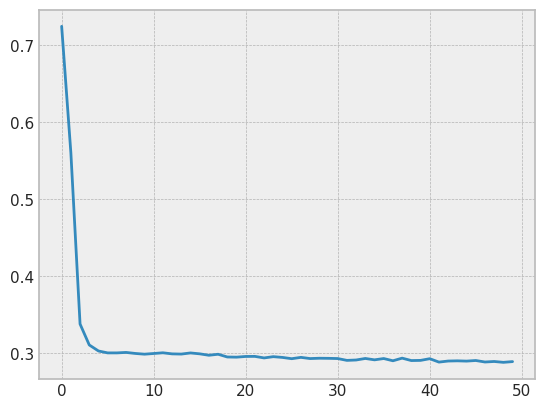

In [18]:
import copy
import torch.optim as optim

seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Initializes generator and discriminator
generator = Generator(5)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)

discriminator = Discriminator()
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss function and optimizer
mse_loss = nn.MSELoss()  # mean square error
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    generator.train()
    discriminator.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            #  Forword Generator for z=0 
            g0 = generator(X_batch,0)

            #  Forword Generator for z=1 
            g1 = generator(X_batch,1)

            a_loss = mse_loss(discriminator(g0), y_batch.reshape(-1,1))
            #b_loss = mse_loss(discriminator(g1), shuffled_y.reshape(-1,1))
            b_loss = -torch.log(torch.sigmoid(mse_loss(discriminator(g1), y_batch.reshape(-1,1))))

            loss = a_loss + b_loss 

            # backward pass
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()
            loss.backward()
            # update weights
            optimizer_G.step()
            optimizer_D.step()    
            # print progress
            bar.set_postfix(mse=float(loss))


    if epoch % 10 == 0:
        print(
                "[Epoch %d/%d] [A loss: %f] [B loss: %f] [G loss: %f]"
                % (epoch, n_epochs, a_loss, b_loss, loss)
            )
            
    # evaluate accuracy at end of each epoch
    generator.eval()
    discriminator.eval()
    
    y_pred = discriminator(generator(X_test,0))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

In [19]:
from sklearn.metrics import r2_score
predicted_y = discriminator(generator(X_test,0))
#predicted_y = discriminator(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9298963694677324


In [20]:
from sklearn.metrics import r2_score
predicted_y = discriminator(generator(X_test,1))
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score -2.3331242702214143


## controllor z에 따른 R2 제어

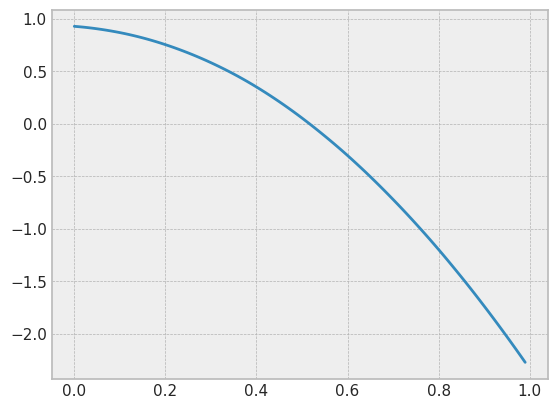

In [21]:
r2s = []
for cb in range(0, 100, 1) :
    predicted_y = discriminator(generator(X_test,cb/100))
    r2 = r2_score(y_test,predicted_y.detach().numpy())
    r2s.append([cb/100,r2])

r2s = np.asarray(r2s)
plt.plot(r2s[:,0],r2s[:,1])

In [22]:
r2s

array([[ 0.        ,  0.92989637],
       [ 0.01      ,  0.92640033],
       [ 0.02      ,  0.92225445],
       [ 0.03      ,  0.91755188],
       [ 0.04      ,  0.91233312],
       [ 0.05      ,  0.90659561],
       [ 0.06      ,  0.90032533],
       [ 0.07      ,  0.89355864],
       [ 0.08      ,  0.88631881],
       [ 0.09      ,  0.87856218],
       [ 0.1       ,  0.87029849],
       [ 0.11      ,  0.86146338],
       [ 0.12      ,  0.85196797],
       [ 0.13      ,  0.84189833],
       [ 0.14      ,  0.83131622],
       [ 0.15      ,  0.82019571],
       [ 0.16      ,  0.80846953],
       [ 0.17      ,  0.79611912],
       [ 0.18      ,  0.78317551],
       [ 0.19      ,  0.76965414],
       [ 0.2       ,  0.75560208],
       [ 0.21      ,  0.74099743],
       [ 0.22      ,  0.7258064 ],
       [ 0.23      ,  0.71001975],
       [ 0.24      ,  0.69371015],
       [ 0.25      ,  0.67682905],
       [ 0.26      ,  0.65936204],
       [ 0.27      ,  0.64132674],
       [ 0.28      ,

## drift의 측정

+ 일단 생 y의 drift
+ reference 는 test dataset 200개
+ 따라서 bucket size = 200

Bucket size 200
Bucket size:200 step_size:190


  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-10-160e0953fd26>:11: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
100%|██████████| 200/200 [00:00<00:00, 1877.74it/s]


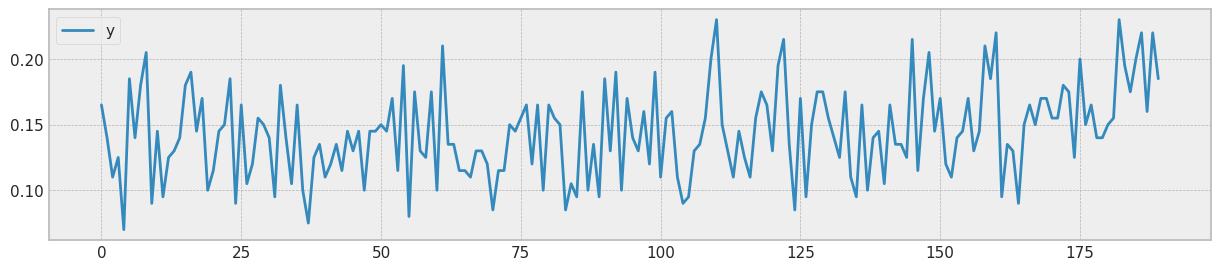

In [23]:

from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))
    
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values, dtype=torch.float32)
        predicted_y = discriminator(generator(tx,0))
        ks = __ks_drift(y_test.reshape(-1,1),predicted_y.detach().numpy())
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()


+ z로 controll한 N개의 predicted_y의 drift
+ z값을 0.0, 0.1, 0.2 3개로 측정한다.
+ classification 처럼.... entropy를 사용한다.

In [24]:
from tqdm import tqdm
from scipy.stats import entropy

seed_everything()

r_gap = 0.05

bucket_size_array=[200] #[10,50,100,200]

y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

In [25]:
ye.shape

(200, 1)

Bucket size 200
Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 988.51it/s]


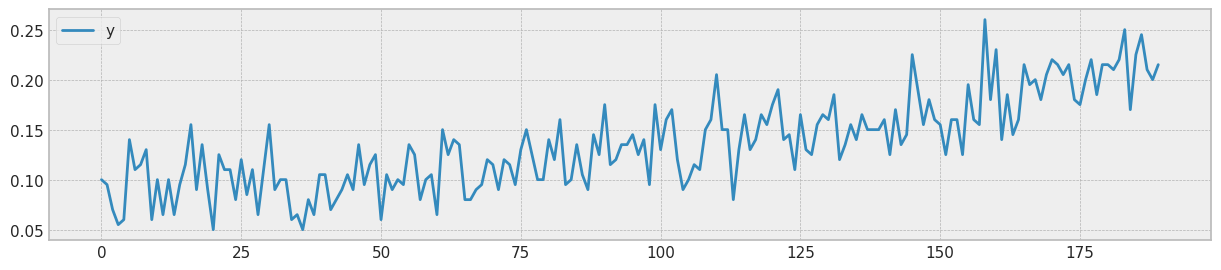

In [26]:
seed_everything()

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values, dtype=torch.float32)
        predicted_y1 = discriminator(generator(tx,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tx,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tx,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## R2과 drift의 관계

+ Noise를 주어 Simulation 한다.
+ r2, ks통계량의 추적

100%|██████████| 10000/10000 [00:12<00:00, 819.59it/s]


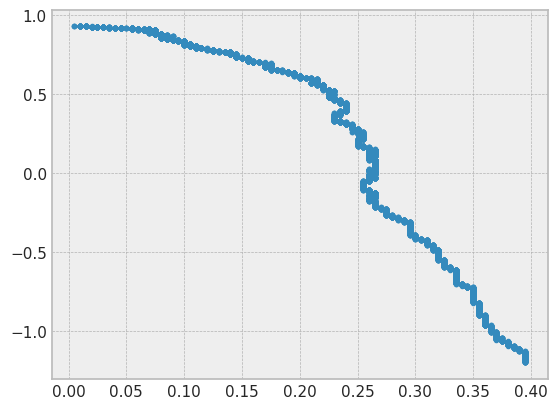

In [27]:
seed_everything()

simulation_count = 10000

sim = []

#tx = torch.tensor(X[0:2000].values, dtype=torch.float32)
y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=0.8)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)

    sim.append([ks[0,0],r2])

sim = np.asarray(sim)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.')


## regression r2 predict model 학습

In [28]:
# Define the regression model
class Regression_r2_predictor(nn.Module):
    
    def __init__(self):
        super(Regression_r2_predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, input_data):
        output = self.model(input_data)
        return output

In [29]:
from sklearn.model_selection import train_test_split

seed_everything()

train_drift, test_drift, train_r2, test_r2 = train_test_split(sim[:,0], sim[:,1], test_size=0.2)

train_drift = torch.tensor(train_drift,dtype=torch.float32)
test_drift = torch.tensor(test_drift,dtype=torch.float32)
train_r2 = torch.tensor(train_r2,dtype=torch.float32)
test_r2 = torch.tensor(test_r2,dtype=torch.float32)

100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


MSE: 0.05
RMSE: 0.22


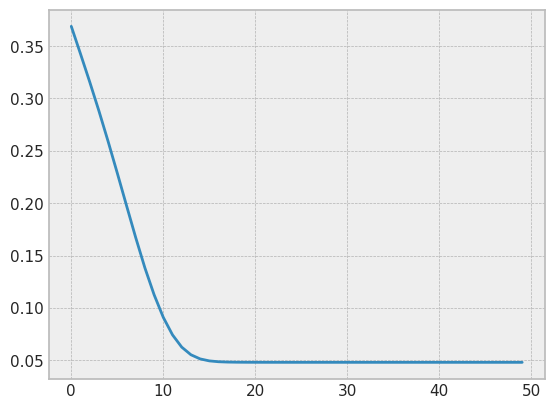

In [30]:
seed_everything()

r2_model = Regression_r2_predictor()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(r2_model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(train_drift), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    r2_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = train_drift[start:start+batch_size].reshape(-1,1)
            y_batch = train_r2[start:start+batch_size].reshape(-1,1)
            # forward pass
            y_pred = r2_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    r2_model.eval()
    y_pred = r2_model(test_drift.reshape(-1,1))
    mse = loss_fn(y_pred.reshape(-1,1), test_r2.reshape(-1,1))
    mse = float(mse)
    history.append(mse)
 
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

In [31]:
# R2 예측의 성능
predicted_y = r2_model(test_drift.reshape(-1,1))
r2 = r2_score(test_r2,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.8781063078613808


## R2 예측의 적용

(38000,)
Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 719.70it/s]


<Axes: >

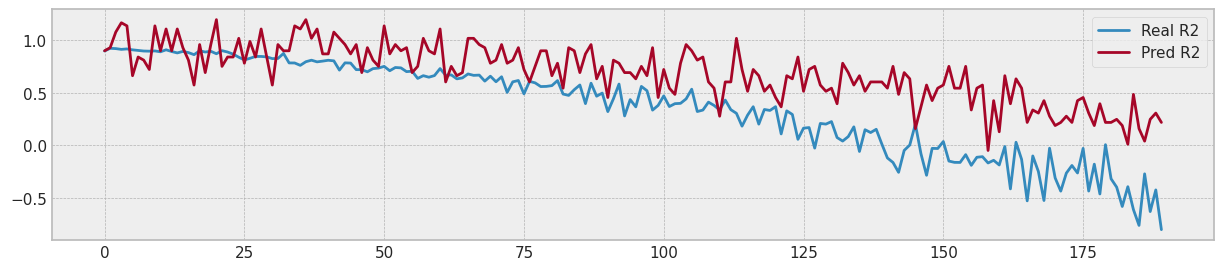

In [32]:
XT = X[2000:]
yT = y[2000:]

print(yT.shape)
bucket_size_array=[200]

y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    print('Bucket size:%d step_size:%d'%(bucket_size,bucket_count))
    r2s = {}
    r2s['Real R2'] = []
    r2s['Pred R2'] = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)

        predicted_y1 = discriminator(generator(tmp_x,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tmp_x,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tmp_x,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = torch.tensor(__ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1)),dtype=torch.float32)
        predicted_r2 = r2_model(ks[:,0]).detach().numpy()[0]

        r2 = r2_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y1)
        r2s['Real R2'].append(r2)
        r2s['Pred R2'].append(predicted_r2)


r2s_df = pd.DataFrame(r2s)
r2s_df.plot(figsize=(15,3))


# 여기서 부터는 G 만 학습 시키는 경우의 실험

+ Generator에 control factor 'z' 를 대입하여, r2가 1~0 까지 전개되도록 학습한다.
+ Discriminator는 별도로 학습한다.

$$
L_1=mse(D(x),y) 
$$

$$
L_2=mse(G(x,z=0),x) - log(softmax(mse(G(x,z=1),x))) 
$$

  2%|▏         | 2/100 [00:00<00:14,  6.89it/s]

[Epoch 0/100] [L1 loss: 0.698023] [L2 loss: 4.375156] [A loss: 4.362331] [B loss: 0.012825]


 12%|█▏        | 12/100 [00:01<00:13,  6.29it/s]

[Epoch 10/100] [L1 loss: 0.271145] [L2 loss: 0.227953] [A loss: 0.183087] [B loss: 0.044866]


 22%|██▏       | 22/100 [00:03<00:11,  6.50it/s]

[Epoch 20/100] [L1 loss: 0.270867] [L2 loss: 0.045555] [A loss: 0.042471] [B loss: 0.003084]


 32%|███▏      | 32/100 [00:04<00:10,  6.53it/s]

[Epoch 30/100] [L1 loss: 0.267580] [L2 loss: 0.023478] [A loss: 0.022609] [B loss: 0.000869]


 42%|████▏     | 42/100 [00:06<00:08,  6.71it/s]

[Epoch 40/100] [L1 loss: 0.263191] [L2 loss: 0.008339] [A loss: 0.007903] [B loss: 0.000436]


 52%|█████▏    | 52/100 [00:08<00:08,  5.96it/s]

[Epoch 50/100] [L1 loss: 0.263022] [L2 loss: 0.002092] [A loss: 0.001875] [B loss: 0.000217]


 61%|██████    | 61/100 [00:10<00:08,  4.65it/s]

[Epoch 60/100] [L1 loss: 0.264106] [L2 loss: 0.000637] [A loss: 0.000551] [B loss: 0.000086]


 72%|███████▏  | 72/100 [00:11<00:04,  6.28it/s]

[Epoch 70/100] [L1 loss: 0.263985] [L2 loss: 0.000326] [A loss: 0.000288] [B loss: 0.000038]


 82%|████████▏ | 82/100 [00:13<00:02,  6.32it/s]

[Epoch 80/100] [L1 loss: 0.262392] [L2 loss: 0.000149] [A loss: 0.000130] [B loss: 0.000020]


 92%|█████████▏| 92/100 [00:14<00:01,  6.68it/s]

[Epoch 90/100] [L1 loss: 0.263473] [L2 loss: 0.000091] [A loss: 0.000080] [B loss: 0.000011]


100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


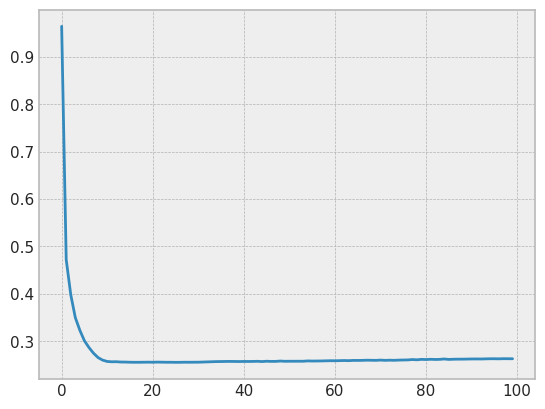

In [33]:
import copy
import torch.optim as optim

seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Initializes generator and discriminator
generator = Generator(5)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)

discriminator = Discriminator()
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss function and optimizer
mse_loss = nn.MSELoss()  # mean square error
 
n_epochs = 100   # number of epochs to run
batch_size = 20  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    generator.train()
    discriminator.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            L1_loss = mse_loss(discriminator(X_batch), y_batch)

            #  Forword Generator for z=0 
            g0 = generator(X_batch,0)

            #  Forword Generator for z=1 
            g1 = generator(X_batch,1)

            a_loss = mse_loss(g0, X_batch)
            b_loss = -torch.log(torch.sigmoid(mse_loss(g1, X_batch)))

            L2_loss = a_loss + b_loss 

            # backward pass
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()
            L1_loss.backward()
            L2_loss.backward()
            # update weights
            optimizer_G.step()
            optimizer_D.step()    
            # print progress
            bar.set_postfix(mse=float(loss))


    if epoch % 10 == 0:
        print(
                "[Epoch %d/%d] [L1 loss: %f] [L2 loss: %f] [A loss: %f] [B loss: %f]"
                % (epoch, n_epochs, L1_loss, L2_loss, a_loss, b_loss)
            )
            
    # evaluate accuracy at end of each epoch
    generator.eval()
    discriminator.eval()
    
    y_pred = discriminator(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)

plt.plot(history)
plt.show()

In [34]:
# 순수 discriminator의 성능
predicted_y = discriminator(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9362350490059933


In [35]:
# z=0 일때 성능
predicted_y = discriminator(generator(X_test,0))
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9363798252334233


In [36]:
# z=1 일때 성능
predicted_y = discriminator(generator(X_test,1))
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score -2.69274472125751


## z controllor 에 따른 R2 제어

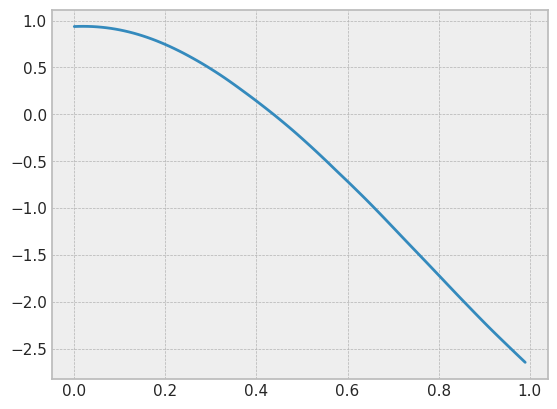

In [37]:
r2s = []
for cb in range(0, 100, 1) :
    predicted_y = discriminator(generator(X_test,cb/100))
    r2 = r2_score(y_test,predicted_y.detach().numpy())
    r2s.append([cb/100,r2])

r2s = np.asarray(r2s)
plt.plot(r2s[:,0],r2s[:,1])

In [38]:
r2s

array([[ 0.        ,  0.93637983],
       [ 0.01      ,  0.93797205],
       [ 0.02      ,  0.93841206],
       [ 0.03      ,  0.93777457],
       [ 0.04      ,  0.93598774],
       [ 0.05      ,  0.93299366],
       [ 0.06      ,  0.92884317],
       [ 0.07      ,  0.92353353],
       [ 0.08      ,  0.91699617],
       [ 0.09      ,  0.9092302 ],
       [ 0.1       ,  0.90027608],
       [ 0.11      ,  0.89002371],
       [ 0.12      ,  0.87863672],
       [ 0.13      ,  0.86609759],
       [ 0.14      ,  0.85221857],
       [ 0.15      ,  0.83714315],
       [ 0.16      ,  0.82093338],
       [ 0.17      ,  0.80359855],
       [ 0.18      ,  0.78508169],
       [ 0.19      ,  0.7653405 ],
       [ 0.2       ,  0.74470131],
       [ 0.21      ,  0.72291575],
       [ 0.22      ,  0.69999621],
       [ 0.23      ,  0.67617567],
       [ 0.24      ,  0.65150462],
       [ 0.25      ,  0.62560971],
       [ 0.26      ,  0.59885947],
       [ 0.27      ,  0.57144459],
       [ 0.28      ,

## drift의 측정

Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 1100.97it/s]


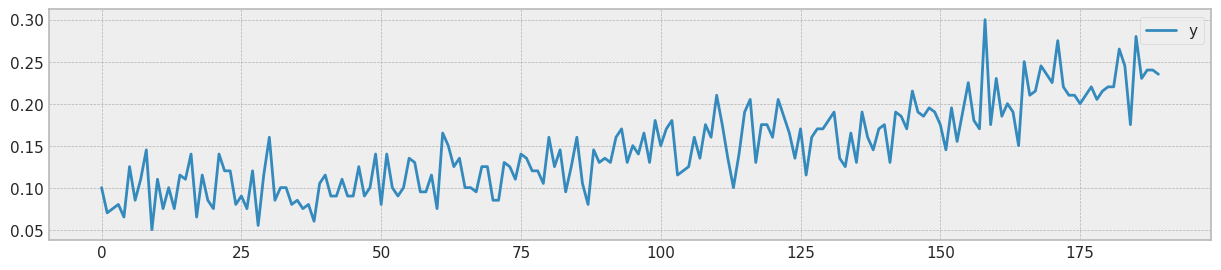

In [39]:
from tqdm import tqdm
from scipy.stats import entropy

seed_everything()

bucket_size_array=[200] #[10,50,100,200]
r_gap = 0.05
y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for bucket_size in bucket_size_array:

    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size:%d step_size:%d'%(bucket_size,step_size))

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values, dtype=torch.float32)
        predicted_y1 = discriminator(generator(tx,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tx,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tx,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## R2 vs. Drift

100%|██████████| 10000/10000 [00:12<00:00, 773.39it/s]


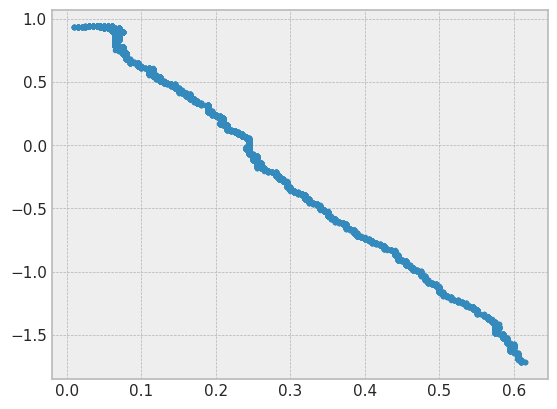

In [40]:
seed_everything()

simulation_count = 10000

sim = []

#tx = torch.tensor(X[0:2000].values, dtype=torch.float32)
y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for sim_count in tqdm(range(simulation_count)):
    # z값을 0~0.13까지 random하게 추출
    z_controller = np.random.uniform(low=0.0, high=0.8)

    predicted_y1 = discriminator(generator(X_test,z_controller)).detach().numpy()
    predicted_y2 = discriminator(generator(X_test,z_controller+r_gap)).detach().numpy()
    predicted_y3 = discriminator(generator(X_test,z_controller+r_gap*2)).detach().numpy()
    predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

    ks = __ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1))

    r2 = r2_score(y_test,predicted_y1)

    sim.append([ks[0,0],r2])

sim = np.asarray(sim)
#drift <- sim[:,0]
#r2 <- sim[:,1]
plt.plot(sim[:,0],sim[:,1],'.')


## 성능 예측 모델

100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


MSE: 0.00
RMSE: 0.05


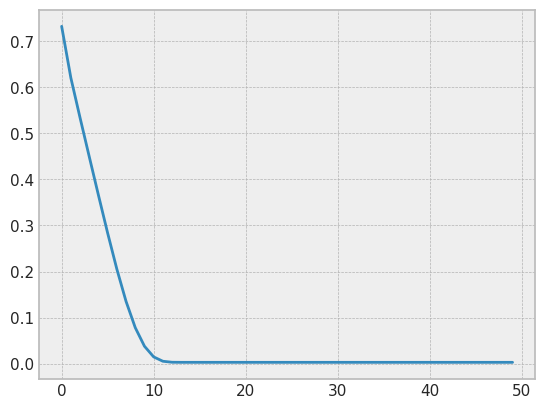

In [41]:
from sklearn.model_selection import train_test_split

seed_everything()

train_drift, test_drift, train_r2, test_r2 = train_test_split(sim[:,0], sim[:,1], test_size=0.2)

train_drift = torch.tensor(train_drift,dtype=torch.float32)
test_drift = torch.tensor(test_drift,dtype=torch.float32)
train_r2 = torch.tensor(train_r2,dtype=torch.float32)
test_r2 = torch.tensor(test_r2,dtype=torch.float32)


r2_model = Regression_r2_predictor()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(r2_model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(train_drift), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    r2_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = train_drift[start:start+batch_size].reshape(-1,1)
            y_batch = train_r2[start:start+batch_size].reshape(-1,1)
            # forward pass
            y_pred = r2_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    r2_model.eval()
    y_pred = r2_model(test_drift.reshape(-1,1))
    mse = loss_fn(y_pred.reshape(-1,1), test_r2.reshape(-1,1))
    mse = float(mse)
    history.append(mse)

print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))
plt.plot(history)
plt.show()

In [42]:
# R2 예측의 성능
predicted_y = r2_model(test_drift.reshape(-1,1))
r2 = r2_score(test_r2,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9957078630790916


## 성능 예측

Bucket size:200 step_size:190


100%|██████████| 190/190 [00:00<00:00, 694.72it/s]


<Axes: >

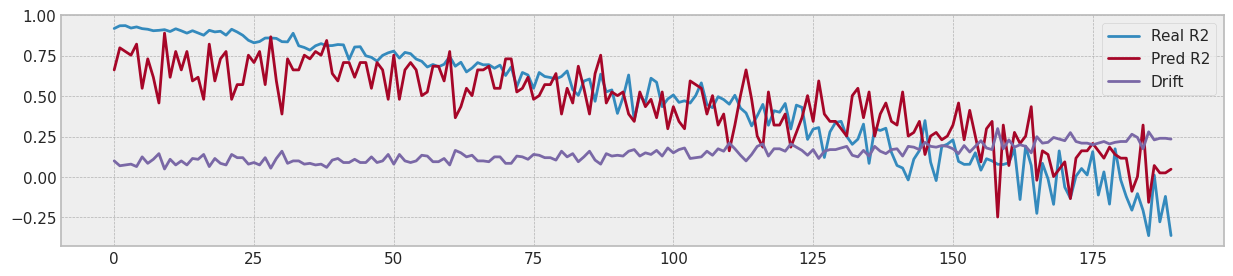

In [43]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

y1 = discriminator(generator(X_test,0.0)).detach().numpy()
y2 = discriminator(generator(X_test,r_gap)).detach().numpy()
y3 = discriminator(generator(X_test,r_gap*2)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1),axis=1).reshape(-1,1)

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    print('Bucket size:%d step_size:%d'%(bucket_size,bucket_count))
    r2s = {}
    r2s['Real R2'] = []
    r2s['Pred R2'] = []
    r2s['Drift'] = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)

        predicted_y1 = discriminator(generator(tmp_x,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tmp_x,r_gap)).detach().numpy()
        predicted_y3 = discriminator(generator(tmp_x,r_gap*2)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = torch.tensor(__ks_drift(ye,entropy(predicted_ys,axis=1).reshape(-1,1)),dtype=torch.float32)
        dr = ks[:,0]
        predicted_r2 = r2_model(dr).detach().numpy()[0]

        r2 = r2_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y1)
        r2s['Real R2'].append(r2)
        r2s['Pred R2'].append(predicted_r2)
        r2s['Drift'].append(dr.detach().numpy()[0])


r2s_df = pd.DataFrame(r2s)
r2s_df.plot(figsize=(15,3))
